In [1]:
import os

from pathlib import Path

import matplotlib.pyplot as plt

from lhotse.augmentation import WavAugmenter
from lhotse.cut import CutSet
from lhotse.dataset.speech_recognition import SpeechRecognitionDataset
from lhotse.features import Fbank, FeatureSetBuilder
from lhotse.recipes.librispeech import download_and_untar, prepare_librispeech, dataset_parts_full

# Settings for paths

In [2]:
root_dir = Path('data')
corpus_dir = root_dir / 'LibriSpeech'
output_dir = root_dir / 'librispeech_nb'

# Select data parts

In [3]:
dataset_parts_full

('dev-clean',
 'dev-other',
 'test-clean',
 'test-other',
 'train-clean-100',
 'train-clean-360',
 'train-other-500')

In [4]:
dataset_parts = ('dev-clean', 'test-clean', 'train-clean-100')

# Download and untar

In [5]:
download_and_untar(root_dir, dataset_parts)

# Prepare audio and supervision manifests

In [6]:
librispeech_manifests = prepare_librispeech(corpus_dir, dataset_parts, output_dir)

# [Optional] Data augmentation

In [7]:
use_data_augmentation = True
augmenter = WavAugmenter.create_predefined('pitch_reverb_tdrop', sampling_rate=16000) if use_data_augmentation else None
# It seems when spawning multiple Python subprocesses with the same sox handle it raises "std::runtime_error: Couldn't close file"
# The issue seems to happen only in a Jupyter notebook on Mac OS X, hence the work around below.
num_jobs = 1 if use_data_augmentation else os.cpu_count()

# Extract features

In [8]:
for partition, manifests in librispeech_manifests.items():
    feature_set_builder = FeatureSetBuilder(
        feature_extractor=Fbank(),
        output_dir=f'{output_dir}/feats_{partition}',
        augmenter=augmenter
    )
    feature_set = feature_set_builder.process_and_store_recordings(
        recordings=manifests['recordings'],
        num_jobs=os.cpu_count()
    )
    librispeech_manifests[partition]['feats'] = feature_set

    cut_set = CutSet.from_manifests(supervisions=manifests['supervisions'], features=feature_set)
    librispeech_manifests[partition]['cuts'] = cut_set
    cut_set.to_json(output_dir / f'cuts_{partition}.json.gz')

# Make pytorch Dataset

In [9]:
cuts_dev = SpeechRecognitionDataset(librispeech_manifests['dev-clean']['cuts'])
cuts_train = SpeechRecognitionDataset(librispeech_manifests['train-clean-100']['cuts'])

# Illustation of an example

THE LADIES


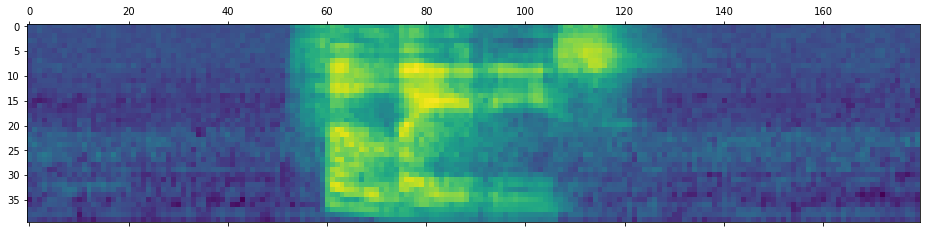

In [10]:
sample = cuts_dev[0]
print(sample['text'])
plt.matshow(sample['features'].transpose(0, 1).flip(0))